In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from matplotlib.pylab import rcParams
from sklearn.preprocessing import StandardScaler
from collections import Counter
from imblearn.over_sampling import SMOTE 

# Conjunto de Dados

## Pré Processamento

Escolher a base de dados que se deseja analisar. As bases escolhidas para o trabalho foram "CM1/Software defect prediction" e "KC1/Software defect prediction", encontradas no repositório _Promise_ (_link_ abaixo).

Fonte: http://promise.site.uottawa.ca/SERepository/datasets-page.html

In [39]:
data = pd.read_csv('cm1.csv')
# data = pd.read_csv('kc1.csv')

Cada coluna recebeu o nome referente à sua posição no conjunto de dados e a última coluna representa as classes das instâncias.

In [40]:
data.head()

,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,Class
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2,2,2,2,1.2,1.2,1.2,1.2,1.4,False
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1,1,1,1,1.0,1.0,1.0,1.0,1.0,True
2,24.0,5.0,1.0,3.0,63.0,309.13,0.11,9.50,32.54,2936.77,...,1,0,6,0,15.0,15.0,44.0,19.0,9.0,False
3,20.0,4.0,4.0,2.0,47.0,215.49,0.06,16.00,13.47,3447.89,...,0,0,3,0,16.0,8.0,31.0,16.0,7.0,False
4,24.0,6.0,6.0,2.0,72.0,346.13,0.06,17.33,19.97,5999.58,...,0,0,3,0,16.0,12.0,46.0,26.0,11.0,False


A classe _LabelEncoder_ é utilizada para substituir os nomes das classes por valores binários.

In [41]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
data.Class = encoder.fit_transform(data.Class)

Abaixo é mostrado a proporção das classes presentes na base de dados escolhida. Verifica-se que ambas as bases utilizadas no trabalho são desbalanceadas. As classes minoritárias nas bases "CM1/Software defect prediction" e "KC1/Software defect prediction" representam 9,8% e 15,4%, respectivamente.

In [42]:
X = data.iloc[:, :-1].values
y = data.Class.values
print('Original dataset shape {}'.format(Counter(y)))

Original dataset shape Counter({0: 449, 1: 49})


Analisando rapidamente os dados, verifica-se que os valores das variáveis variam consideravelmente. Logo, os dados são escalonados de modo que seus valores variem entre -1 e 1.

In [43]:
sc_X = StandardScaler()
X = sc_X.fit_transform(X)

# Bagging & Random Subspace

In [44]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import roc_auc_score
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import f1_score

In [45]:
rcParams['figure.figsize'] = 12, 3

Será utilizada a classe _StratifiedKFold_ para a separação dos conjuntos de treinamento e teste. O termo _Stratified_ faz referência à preservação da proporção das classes em cada _fold_ criado.

In [46]:
from sklearn.model_selection import StratifiedKFold

A função _Generate _ Analysis()_ plota os gráficos de barras de cada métrica de escore para os diferentes modelos de combinação de classificadores. Além dos gráficos, tabelas também são geradas de modo que auxilie a visualização dos resultados do trabalho. Os parâmetros da função são os conjuntos X (valores dos atributos) e y (classes) pré processados.

In [49]:
def Generate_Analysis(X, y):
    name1 = ['Bagging', 'Random Subspace']
    name2 = ['Árvores de Decisão', 'Perceptron']
    features = [1.0, 0.5]
    models = [DecisionTreeClassifier(), Perceptron(tol = 0.0001, max_iter = 10000)]
    sizes = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]
    for f, feature in enumerate(features):
        for m, model in enumerate(models):
            skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
            metrics = np.zeros((len(sizes), 4))
            for train_index, test_index in skf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                sm = SMOTE(random_state=42)
                X_train, y_train = sm.fit_sample(X_train, y_train)
                
                for i, size in enumerate(sizes):
                    # All data points
                    bg = BaggingClassifier(model,
                                             max_samples = size,
                                             max_features = feature,
                                             n_estimators = 100,
                                             random_state = 42)
                    bg.fit(X_train, y_train)
                    y_pred = bg.predict(X_test)
                    metrics[i, :] += [bg.score(X_test, y_test),
                        roc_auc_score(y_test, bg.predict_proba(X_test)[:,1]),
                          geometric_mean_score(y_test, y_pred),
                          f1_score(y_test, y_pred)]
            metrics = metrics / skf.n_splits
                       
            barWidth = 0.1
            # Set position of bar on X axis
            r1 = np.arange(metrics.shape[0])
            r2 = [x + barWidth for x in r1]
            r3 = [x + barWidth for x in r2]
            r4 = [x + barWidth for x in r3]

            # Make the plot
            plt.bar(r1, metrics[:, 0], width=barWidth, edgecolor='white', label='Acurácia')
            plt.bar(r2, metrics[:, 1], width=barWidth, edgecolor='white', label='AUC')
            plt.bar(r3, metrics[:, 2], width=barWidth, edgecolor='white', label='G-Mean')
            plt.bar(r4, metrics[:, 3], width=barWidth, edgecolor='white', label='F-Measure')

            # Add xticks on the middle of the group bars
            plt.ylim([0., 1.01])
            plt.xlabel('Porcentagem de dados no treinamento')
            plt.ylabel('Escore')
            plt.xticks([r + barWidth for r in range(metrics.shape[0])], ['100%', '90%', '80%', '70%', '60%', '50%'])

            # Create legend & Show graphic
            plt.legend(loc = 'upper right')
            plt.title(name1[f]+ ' - '+ name2[m])
            plt.show()
            
            df = pd.DataFrame(data = metrics, index = sizes, columns = ['Acurácia', 'AUC', 'G-Mean', 'F-Measure'])
            print(df)
    return

Resultados gerados abaixo.

/home/CIN/jvcm/ensembleenv/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/CIN/jvcm/ensembleenv/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/CIN/jvcm/ensembleenv/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/CIN/jvcm/ensembleenv/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/CIN/jvcm/ensembleenv/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/CIN/jvcm/ensembleenv/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/CIN/jvcm/ensembleenv/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarnin

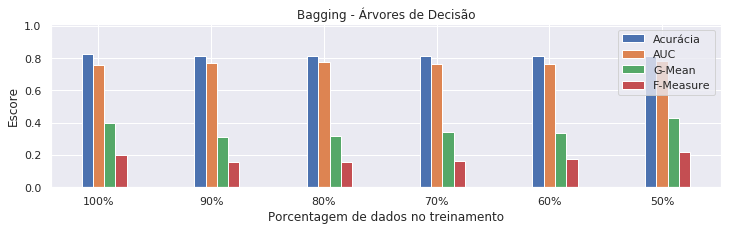

     Acurácia       AUC    G-Mean  F-Measure
1.0  0.827167  0.755616  0.400446   0.198475
0.9  0.815167  0.768643  0.314596   0.157706
0.8  0.813167  0.773804  0.314852   0.157554
0.7  0.813250  0.764581  0.343591   0.160498
0.6  0.815000  0.765284  0.333857   0.176515
0.5  0.815083  0.779965  0.431430   0.220094


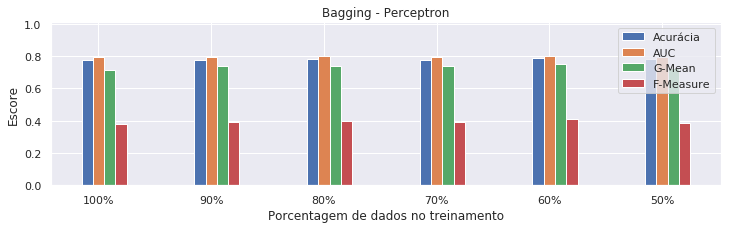

     Acurácia       AUC    G-Mean  F-Measure
1.0  0.779000  0.793551  0.716119   0.378182
0.9  0.777000  0.795452  0.738223   0.392689
0.8  0.781000  0.797747  0.740353   0.396525
0.7  0.779000  0.796662  0.738008   0.391524
0.6  0.787000  0.800909  0.753724   0.412285
0.5  0.781083  0.792414  0.727778   0.385172


/home/CIN/jvcm/ensembleenv/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/CIN/jvcm/ensembleenv/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/CIN/jvcm/ensembleenv/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/CIN/jvcm/ensembleenv/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/CIN/jvcm/ensembleenv/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/CIN/jvcm/ensembleenv/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/CIN/jvcm/ensembleenv/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarnin

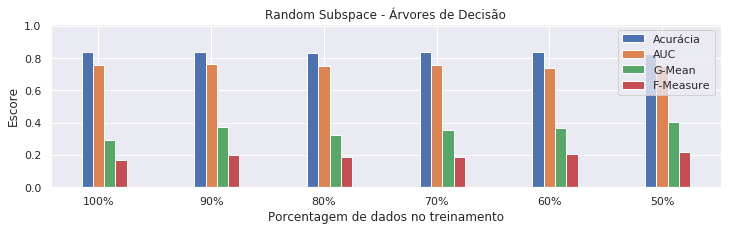

     Acurácia       AUC    G-Mean  F-Measure
1.0  0.839250  0.758443  0.293180   0.166178
0.9  0.837417  0.762457  0.372337   0.202029
0.8  0.833167  0.750294  0.325488   0.187522
0.7  0.837250  0.756629  0.355233   0.188634
0.6  0.835417  0.738997  0.369225   0.204383
0.5  0.827250  0.750764  0.405626   0.219807


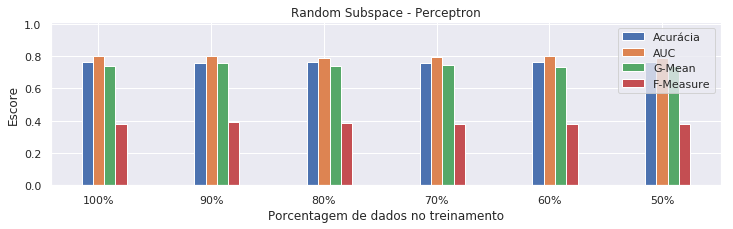

     Acurácia       AUC    G-Mean  F-Measure
1.0  0.760917  0.802412  0.739135   0.377285
0.9  0.758833  0.798521  0.756982   0.391238
0.8  0.762917  0.788634  0.740624   0.384606
0.7  0.756917  0.795337  0.746928   0.379409
0.6  0.764750  0.800040  0.731662   0.381873
0.5  0.762750  0.789028  0.739666   0.380821


In [50]:
Generate_Analysis(X,y)